<a href="https://colab.research.google.com/github/RockZhang29/EC601_Project/blob/main/%E2%80%9CEC500_ProgrammingSet1_SOLUTIONS_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTANT:** You should run this using a GPU! In Colab, go to the "runtime" menu, choose "change runtime type", and select "GPU" from the hardware accelerator dropdown menu. Otherwise, this might take much longer. With the GPU, it should run in about 10 minutes or less.

Although this homeo

There are **3** places you need to write code in this notebook, for questions **1**, **2a** and **2b**.

To turn in this homework: download as .ipynb (File -> download as .ipynb). Make the filename YOURNAME_HW3.ipynb and send via email attachment to opt4mlclass+program1@gmail.com with your name in the subject line.

In [ ]:
#imports
import torch, torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
import numpy as np
from matplotlib import pyplot as plt
from collections.abc import Iterable

In [ ]:
# Basic SGD implementation for reference.
# for base class, see https://github.com/pytorch/pytorch/blob/master/torch/optim/optimizer.py
# for official pytorch SGD implementation, see https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

class SGD(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD, self).__init__(params, {'lr': lr})

    # The params argument can be a list of pytorch variables, or
    # a list of dicts. If it is a list of dicts, each dict should have 
    # a key 'params' that is a list of pytorch variables,
    # and optionally another key 'lr' that specifies the learning rate
    # for those variables. If 'lr' is not provided, the default value
    # is the single value provided as an argument after params to this
    # constructor.
    # If params is just a list of pytorch variables, it is the same
    # as if params were actually a list containing a single dictionary
    # whose 'params' key value is the list of variables.
    # See examples in following code blocks for use of params.

    # Set up an iteration counter.
    # self.state[p] is a python dict for each parameter p
    # that can be used to store various state useful in the optimization
    # algorithm. In this case, we simply store the iteration count, although
    # it is not used in this simple algorithm.
    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0


  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']

      # it is common practice to call the model parameters p in code.
      # in class we follow more closely analytical conventions, in which the
      # parameters are often called w for weights.
      for p in group['params']:
        if p.grad is None:
          continue
        
        # Update the iteration counter (again, this is not actually used in this algorithm)
        state = self.state[p]
        step = state['step']
        step += 1
        
        # Perform the SGD update. p.grad holds the gradient of the loss
        # with respect to p.
        p.add_(p.grad, alpha=-lr)

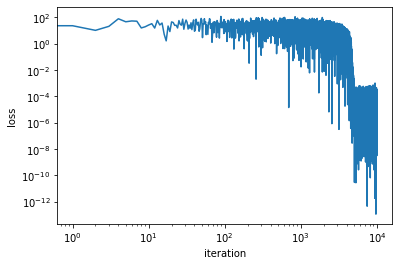

In [ ]:
#Simple linear regression problem
dimension = 10
num_iter = 10000

mean = torch.zeros(dimension)
std = torch.ones(dimension)

def loss_func(w_hat, b_hat, w_true, b_true):
  # simple linear regression problem, although
  # slightly non-standard loss. See pytorch docs
  # for description of loss function.

  # features
  x = torch.normal(mean, std)

  # true label is a linear function of features plus noise.
  noise = np.random.normal(0.0, 0.01)
  y_true = torch.dot(x, w_true) + b_true + noise

  y_hat = torch.dot(x, w_hat) + b_hat

  loss = torch.nn.SmoothL1Loss()
  return loss(y_hat, y_true)

w_true = 10*torch.normal(mean, std)

# make true bias term quite large so that it is better
# to have a high learning rate for the bias. This makes
# it advantageous to use the params as a dict in the 
# following cell.
b_true = torch.normal(torch.zeros(1), torch.ones(1))


# declare variables that will actually be trained.
# "requires_grad" tells pytorch that it may have to compute
# gradients with respect to these variables.
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = SGD([w, b], 0.010)

losses = []

for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

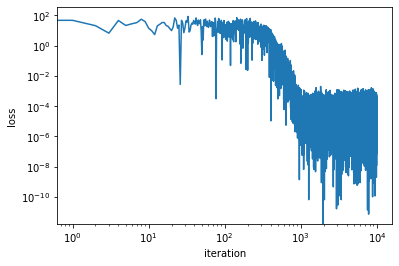

In [ ]:

w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
param_groups = [{'params': [w], 'lr': 0.1}, {'params': [b], 'lr': 0.01}]
optimizer = SGD(param_groups, 0.10)

losses = []
for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

Remarks

1. What does `@torch.no_grad` do? 

This tells the pytorch not to record gradient operations for anything that happens inside the function, so it will not be able to compute derivatives of these operations. However, this is important to enable because some operations (like performing an update) inherently should not be differentiated, and pytorch will thrown an error if you do not explicitly tell it that you do not want to differentiate through this operation.

2. Why do we need `torch.enable_grad` when using the closure?

Computing the closure (which is essentially a fancy name for "function") is an alternative to providing the gradient to the optimization step. Instead, the loss $\ell(w_t, z_t)$ is computed by the closure. However, the closure might need to compute some derivatives, so we turn on `torch.enable_grad`.

3. Why do we use `p.add_` as opposed to `p = p - lr*grad`?

All pytorch variables (and all python variables except for simple things like integers and chars for that matter) are essentially *pointers*. That is, `p` is a name for an area of computer memory that contains the data for some vector. This makes it fast to pass `p` around to various functions, but if we do `p = z`, this actually means that now `p` refers to the same memory location that `z` is referring to. This is a problem, because the original data has not been changed. `p.add_` instead will change the original data. If you are not familiar with this concept in programming, you may want to do some reading on pass-by-reference vs pass-by-value and pointers.


**Question 1**

1. Fill out the class below to implement a version of SGD that sets the "adaptive" learning rate:
$$
\eta_t = \frac{lr}{\sqrt{G_t}}
$$
$lr$ (for "learning rate") is provided as input to the algorithm, $t$ is the current iteration count, and
$$
G_t = \sum_{i=1}^t \|\nabla \ell(w_t, z_t)\|^2
$$
If you are familiar with the AdaGrad update, note that this is NOT the same because of the presence of the norm.

Read the `__init__` method carefully as it has changed slightly from the original `SGD` class above.



In [ ]:
class SGD_adaptive(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD_adaptive, self).__init__(params, {'lr': lr})

    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0

        # make a dictionary entry for Gt. It is just a 1-D vector (a scalar).
        # device=p.device tells pytorch to allocate the memory for Gt on the 
        # same device (e.g. CPU or GPU) as the data for the variable p.
        state['Gt'] = torch.zeros(1, device=p.device)

  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']
      for p in group['params']:
        if p.grad is None:
          continue
        
        ####### YOUR CODE HERE ########

        # Update the iteration counter (again, this is not actually used in this algorithm)
        state = self.state[p]
        state['step'] += 1
        step = state['step']

        state['Gt'].add_(torch.norm(p.grad)**2)
        
        p.addcdiv_(p.grad, torch.sqrt(state['Gt']), value=-lr)


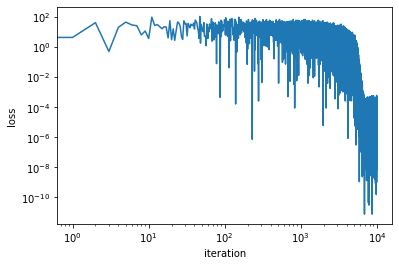

In [ ]:
w = torch.zeros(dimension, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = SGD_adaptive([w, b], 1.0)
losses = []
for t in range(num_iter):
  optimizer.zero_grad()
  loss = loss_func(w, b, w_true, b_true)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.xscale('log')
plt.yscale('log')
plt.show()

See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py for some similar example of how to set up the process below, from which much of this was copied.

In [ ]:
## These commands create two pytorch "DataLoader" objects, one for training
# data and one for testing data.
# A DataLoader object is essentially a list of training/testing examples with
# some extra code attached by pytorch that can send the data to GPUs and other
# useful things.

# The following three commands produce a torchvision dataset object for both
# training and testing data on the CIFAR10 dataset, which is a dataset of images.
# these objects are like lists of vectors (the "transform" specifies a function
# that converts images to vectors").
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
CIFAR_train = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False, transform=transform)


# The next two lines produce the actual DataLoaders. The batch_size argument sets
# the batch size, so that the DataLoader will appear like a list [a,b,c...] where
# each entry of the list is a batch of batch_size examples. 
# Setting shuffle=True makes it so that when you start iterating over the examples
# in the DataLoader, it will first shuffle the order of the list.
trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=16,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=256,
                                          shuffle=True)

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cuda:0


In [ ]:
## Please read the function signatures and doc string for "train_resnet" function.
# You do not need to otherwise understand how it works to do this homework. ##

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_resnet(optimizer, train_loader, device, lrs, wd=0.01, model=None):
  '''
  Trains a resnet model on CIFAR10 data.

  args:
    optimizer: optimizer class that will be instantiated inside this function.
    train_loader: pytorch DataLoader object that provides the training examples.
    device: pytorch device to use (e.g. a GPU).
    lrs: list of learning rates. The length of the list is the number of epochs
      to train for. At the start of the ith epoch, the 'lr' parameter of the
      optimizer will be set to lrs[i].
    wd: l2 regularization constant.
    model: can provide a preset pytorch model to train from a checkpoint. If 
      None, will instantiate a fresh resnet18 model.

  returns:
    the trained pytorch model object.
  '''

  if model is None:
    model = torchvision.models.resnet18(pretrained=False)
  model.to(device)


  # define \ell as the cross-entropy function.
  # this function as implemented in pytorch actually combines both the softmax
  # and the cross entropy function into one. As a result, it is
  # is non-negative, smooth, Lipschitz, and convex in its argument, which
  # are the predicted scores for various classes output by some model.
  # Note that this does NOT necessarily imply that it has these properties
  # with respect to the parameters of the model.
  cross_entropy_loss = torch.nn.CrossEntropyLoss()

  optimizer = SGD_adaptive(model.parameters(), lrs[0])

  num_epochs = len(lrs)

  average_loss = 0.0

  for epoch, lr in enumerate(lrs):#range(num_epochs):
    # iterate over training set.
    # i is index of example, data is the example (e.g. z_i).
    # because shuffle=True when defining the trainloader,
    # the training set is shuffled after every complete pass.

    adjust_learning_rate(optimizer, lr)

    for i, data in enumerate(train_loader):
      # unpack the example data: inputs is a batch of images,
      # labels is a batch of labels.
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # pytorch will keep details from old gradients around in case you are going
      # to differentiate something else. We therefore need to delete this old
      # data before computing the loss so that we only have the gradient
      # for this iteration.
      optimizer.zero_grad()

      predicted_labels = model.forward(inputs)
      loss = cross_entropy_loss(predicted_labels, labels)

      weight_decay = wd * 0.5 * sum([torch.linalg.norm(p)**2 for p in model.parameters()])

      regularized_loss = loss + weight_decay

      # tell pytorch to compute some gradients
      regularized_loss.backward()

      optimizer.step()

      

      average_loss += (loss.item() - average_loss)/(i+1)

      if i % 200 == 199: 
        print('[In epoch %d, iteration %d] loss: %.3f' %
              (epoch + 1, i+1, average_loss))


    print('[After epoch %d] loss: %.3f' %
          (epoch + 1, average_loss))
    average_loss = 0.0

  print('Finished Training')

  return model


In [ ]:
trained_model = train_resnet(SGD_adaptive, trainloader, device, lrs=[0.1, 0.1, 0.1])

[In epoch 1, iteration 200] loss: 2.755
[In epoch 1, iteration 400] loss: 2.394
[In epoch 1, iteration 600] loss: 2.240
[In epoch 1, iteration 800] loss: 2.153
[In epoch 1, iteration 1000] loss: 2.087
[In epoch 1, iteration 1200] loss: 2.045
[In epoch 1, iteration 1400] loss: 2.011
[In epoch 1, iteration 1600] loss: 1.981
[In epoch 1, iteration 1800] loss: 1.955
[In epoch 1, iteration 2000] loss: 1.936
[In epoch 1, iteration 2200] loss: 1.915
[In epoch 1, iteration 2400] loss: 1.897
[In epoch 1, iteration 2600] loss: 1.881
[In epoch 1, iteration 2800] loss: 1.866
[In epoch 1, iteration 3000] loss: 1.853
[After epoch 1] loss: 1.845
[In epoch 2, iteration 200] loss: 1.614
[In epoch 2, iteration 400] loss: 1.620
[In epoch 2, iteration 600] loss: 1.611
[In epoch 2, iteration 800] loss: 1.610
[In epoch 2, iteration 1000] loss: 1.608
[In epoch 2, iteration 1200] loss: 1.607
[In epoch 2, iteration 1400] loss: 1.605
[In epoch 2, iteration 1600] loss: 1.606
[In epoch 2, iteration 1800] loss: 1.

In [ ]:
# These functions take input a trained model and return either the train or
# test accuracy.
def get_train_accuracy(trained_model):
  correct = 0
  total = 0
  with torch.no_grad():
    trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=256, num_workers=2)
    for data in trainloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

def get_test_accuracy(trained_model):
  correct = 0
  total = 0
  with torch.no_grad():
    testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=256, num_workers=2)
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = trained_model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [ ]:
test_accuracy = get_test_accuracy(trained_model)
print("test accuracy: %d", test_accuracy)

test accuracy: %d 49.25


**Question 2a** Write a function that returns a DataLoader object (like the `trainloader` variable) for the training set that uses the provided argument as a batch size.

In [ ]:
def get_trainloader(batch_size):
  ### YOUR CODE HERE ###
  trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=batch_size,
                                            shuffle=True)
  return trainloader


**Question 2b** Now, for each batch size in `[16, 64, 256]`, populate the dictionary `trained_models` with a model trained using that batch size for three epochs using `train_resnet`, the `SGD_adaptive` algorithm. Then run the next cell, which will print the train and test accuracies. Try to tune the learning rate schedules to get the best test performance at batch size 16. You should get close to or better than 70%.

In [ ]:
batch_size_list = [16, 64, 256]
trained_models = {16: None, 64: None, 256: None}
for batch_size in batch_size_list:
  lrs = [None, None, None]
  ### YOUR CODE HERE ###
  lrs = [1.0, 1.0, 0.1]
  trainloader_for_batch_size = get_trainloader(batch_size)
  trained_models[batch_size] = train_resnet(SGD, trainloader_for_batch_size, device, lrs=lrs)

[In epoch 1, iteration 200] loss: 2.225
[In epoch 1, iteration 400] loss: 2.002
[In epoch 1, iteration 600] loss: 1.905
[In epoch 1, iteration 800] loss: 1.832
[In epoch 1, iteration 1000] loss: 1.780
[In epoch 1, iteration 1200] loss: 1.744
[In epoch 1, iteration 1400] loss: 1.710
[In epoch 1, iteration 1600] loss: 1.676
[In epoch 1, iteration 1800] loss: 1.652
[In epoch 1, iteration 2000] loss: 1.627
[In epoch 1, iteration 2200] loss: 1.605
[In epoch 1, iteration 2400] loss: 1.585
[In epoch 1, iteration 2600] loss: 1.569
[In epoch 1, iteration 2800] loss: 1.552
[In epoch 1, iteration 3000] loss: 1.538
[After epoch 1] loss: 1.527
[In epoch 2, iteration 200] loss: 1.203
[In epoch 2, iteration 400] loss: 1.216
[In epoch 2, iteration 600] loss: 1.221
[In epoch 2, iteration 800] loss: 1.217
[In epoch 2, iteration 1000] loss: 1.207
[In epoch 2, iteration 1200] loss: 1.204
[In epoch 2, iteration 1400] loss: 1.198
[In epoch 2, iteration 1600] loss: 1.193
[In epoch 2, iteration 1800] loss: 1.

In [ ]:
for batch_size in batch_size_list:
  test_accuracy = get_test_accuracy(trained_models[batch_size])
  train_accuracy = get_train_accuracy(trained_models[batch_size])
  print("[batch size %d] train accuracy: %d , test accuracy: %d" % (batch_size, train_accuracy, test_accuracy))

[batch size 16] train accuracy: 75 , test accuracy: 71
[batch size 64] train accuracy: 76 , test accuracy: 71
[batch size 256] train accuracy: 73 , test accuracy: 68
